This notebook contains the computer vision task aimed to perform the computer vision task that goes within a NILM framework. 

# Imports

### Librairies


In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import torchvision
from torchvision import models,transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

### Data

In [2]:
!git clone https://github.com/jcGourcuff/customNILMdataSet.git

fatal: destination path 'customNILMdataSet' already exists and is not an empty directory.


In [3]:
!ls

customNILMdataSet  sample_data


In [4]:
root_dir = 'customNILMdataSet/'

# Set up



### Class encoding



In [5]:
classes = ['residuals', 'oven', 'refrigerator', 'dishwasher', 'kitchen_outlets', 'lighting', 'washer_dryer', 'microwave', 'bathroom_gfi']
lab_encoder= OneHotEncoder(sparse = False)
lab_encoder.fit([[name] for name in classes])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

### Data set embedding

In [6]:
class BoxDataSet(Dataset):

    def __init__(self, transform, encoder, batch_size, nb_app):
        self.labels = pd.read_csv(root_dir + str(nb_app) + '_apps/labels.csv', compression = 'zip').set_index('id')
        self.transform = transform
        self.encoder = encoder
        self.batch_size = batch_size
        self.nb_app = nb_app

    def __len__(self):
        return self.batch_size*(self.labels.shape[0]//self.batch_size)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()
        id = self.labels.index[idx]
        label = torch.FloatTensor(self.encoder.transform([[self.labels.loc[id,'label']]])[0])
        img = self.extract_img(id)

        sample = {'id':id,'image':img,'label':label}

        return sample

    def extract_img(self, img_id):
        img_name = root_dir + str(self.nb_app) + '_apps/images/' + str(img_id) + '.png'
        try:
          img = Image.open(img_name) # open the image file
          img.verify() # verify that it is, in fact an image
          img.close()
        except (IOError, SyntaxError) as e:
          print('Bad file:', img_name)
        img =  np.array(Image.open(img_name).convert("RGB"))
        img = torch.as_tensor(self.transform(img))[:,-4850:,:]
        return img

#### Data preprocessing

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform_image = transforms.Compose([transforms.ToTensor(),normalize])

#### Vizualisation

In [8]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.figure(figsize = (40,8) )
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

#### Test data loading

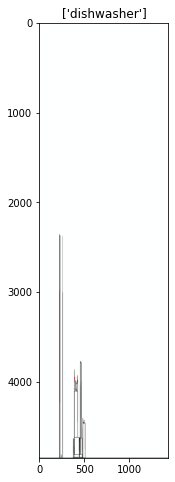

In [9]:
test_set = BoxDataSet(transform=transform_image, encoder = lab_encoder, batch_size = 1, nb_app = 2)
test_loader = DataLoader(test_set, batch_size = 1, shuffle=True, num_workers = 1)

batch_test = next(iter(test_loader))
out = torchvision.utils.make_grid(batch_test['image'])
imshow(out, title=[lab_encoder.inverse_transform([batch_test['label'][x].numpy()])[0][0]for x in range(1)])

### Using GPU

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


# Features precomputing

In [11]:
#Model used for computing the features
pretrained_model = models.resnet18(pretrained = True).to(device)
pretrained_model_feats = nn.Sequential(*list(pretrained_model.children())[:-1])
for param in pretrained_model_feats.parameters():
    param.requires_grad = False

In [16]:
def preconvfeat(dataloader):
    print("Precomputing features...")
    conv_features = []
    labels_list = []
    N = len(dataloader)
    k=0
    for data in dataloader:
        print("\r{}%".format(np.round(100*k/N, decimals = 2)), end = '')
        k+=1
        inputs = data['image'].to(device)
        labels = data['label'].to(device)
        x = pretrained_model_feats(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())

        if k == 100 :
          break

    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)



In [17]:
conv_feats, conv_labels = preconvfeat(test_loader)

Precomputing features...
0.74%

In [22]:
datasetfeat = [[torch.from_numpy(f).type(torch.float),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feats,conv_labels)]
datasetfeat = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat]
loaderfeat = DataLoader(datasetfeat, batch_size=33, shuffle=True)

# Model creation

In [24]:
class BoxNet(nn.Module):
    """
    Implements the NN that outputs the proba at time t that the corresponding app is on.
    """

    def __init__(self, output_size):
        super(BoxNet, self).__init__()
        self.output_size = output_size


        #self.model = models.resnet18(pretrained = True)

        #for param in self.model.parameters():
        #    param.requires_grad = False

        self.model = nn.Sequential(nn.Dropout(inplace=False),
                                nn.Linear(512, 512),
                                nn.ReLU(inplace=True),
                                nn.BatchNorm1d(512),
                                nn.Dropout(inplace = False),
                                nn.Linear(512, 512),
                                nn.ReLU(inplace=True),
                                nn.BatchNorm1d(512),
                                nn.Dropout(inplace = False),
                                nn.Linear(512, self.output_size))


    def forward(self, x):
        x = self.model(x)
        return x

# Training and testing loops

In [26]:
def train_model(model,dataloader,size,epochs=1,optimizer=None):
    model.train()
    batch_count = 1
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        for inputs, targets in dataloader:
            print("\rbatch {}".format(batch_count), end = '')
            batch_count+=1
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs,targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(F(outputs.data),1)
            # statistics
            running_loss += loss.data.item()
            _,classs =  torch.max(targets,1)
            running_corrects += torch.sum(preds == classs)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

# Instanciating and training

### Training without selecting the images

In this first part we will train the model on dignals composed of a pre-defined number of apps. There is no selction made on the images we pick. Thus there are high chances that the model overfits over-represented classes and that parasite samples come to blur the rules we are trying to infer.

In [29]:
nb_outputs_ = 9

In [30]:
BoxModel = BoxNet(nb_outputs_).to(device)

In [31]:
F = nn.Sigmoid().to(device)
loss_fn = nn.BCEWithLogitsLoss().to(device)
batch_size_ = 1
lr_ = 0.001
optimizer = torch.optim.Adam(BoxModel.parameters(), lr=lr_)

In [31]:
Set_2apps = BoxDataSet(transform=transform_image, encoder = lab_encoder, batch_size = batch_size_, nb_app = 2)
Loader_2apps = DataLoader(Set_2apps, batch_size = batch_size_, shuffle=True, num_workers = 1)

In [32]:
train_model(BoxModel,dataloader = loaderfeat, size = len(loaderfeat),epochs=10,optimizer=optimizer)

batch 1

RuntimeError: ignored